# MergeSpectroPhotoFactory

- creation date : July 8th 2019

- author Sylvie Dagoret

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
from dateutil import parser   # parser of string into datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec

import numpy as np
import os
from scipy.interpolate import interp1d

from astropy.time import Time
from astropy.table import Table,QTable

import re

In [2]:
import os
from os import listdir
from os.path import isfile, join
import re
import sys

if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
print('workbookDir: ' + workbookDir)

spectractordir=workbookDir+"/../../Spectractor"
print('spectractordir: ' + spectractordir)
toolsdir=workbookDir+"/../common_tools"
print("toolsdir:",toolsdir)


sys.path.append(workbookDir)
sys.path.append(spectractordir)
sys.path.append(os.path.dirname(workbookDir))
sys.path.append(toolsdir)

from libatmscattering import *

workbookDir: /Users/dagoret/MacOSX/GitHub/LSST/SpectractorAnaAtm19/ana_20190215_HD116405_Filtre_None
spectractordir: /Users/dagoret/MacOSX/GitHub/LSST/SpectractorAnaAtm19/ana_20190215_HD116405_Filtre_None/../../Spectractor
toolsdir: /Users/dagoret/MacOSX/GitHub/LSST/SpectractorAnaAtm19/ana_20190215_HD116405_Filtre_None/../common_tools


In [3]:
plt.rcParams["axes.labelsize"]="large"
plt.rcParams["axes.linewidth"]=2.0
plt.rcParams["xtick.major.size"]=8
plt.rcParams["ytick.major.size"]=8
plt.rcParams["ytick.minor.size"]=5
plt.rcParams["xtick.labelsize"]="large"
plt.rcParams["ytick.labelsize"]="large"

plt.rcParams["figure.figsize"]=(10,10)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
#plt.rcParams['axes.facecolor'] = 'blue'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
plt.rcParams['lines.markersize'] = 5  # markersize, in points
plt.rcParams['grid.alpha'] = 0.75 # transparency, between 0.0 and 1.0
plt.rcParams['grid.linestyle'] = '-' # simple line
plt.rcParams['grid.linewidth'] = 0.4 # in points
plt.rcParams['font.size'] = 13

# Utility functions

In [4]:
def GetTables(tablesdir):
    """
    GetTables(tablesdir)
     input : directory of tables
     
     Read tables geerated by processgreyattenuation.py
     
    """
    fn_info=os.path.join(tablesdir,"Info.npy")
    fn_wl=os.path.join(tablesdir,"Lambdas_ref.npy")
    fn_msk=os.path.join(tablesdir,"Mask.npy")
    fn_att=os.path.join(tablesdir,"MAttenuation_mean_ALL.npy")
    fn_atterr=os.path.join(tablesdir,"MAttenuation_Err_ALL.npy")

    general_info=np.load(fn_info,allow_pickle=True)
    Lambdas_ref=np.load(fn_wl,allow_pickle=True)
    mask= np.load(fn_msk,allow_pickle=True)
    
    #read masked arrays
    compressed=np.load(fn_att)
    values = np.zeros_like(mask, dtype=compressed.dtype)
    np.place(values, ~mask, compressed)
    MAttenuation_mean_ALL = np.ma.MaskedArray(values, mask)
    
    compressed=np.load(fn_atterr)
    values = np.zeros_like(mask, dtype=compressed.dtype)
    np.place(values, ~mask, compressed)
    MAttenuation_Err_ALL = np.ma.MaskedArray(values, mask)
    
    
    
    fn_msk_mag=os.path.join(tablesdir,"MMagMask.npy")
    fn_mag=os.path.join(tablesdir,"MMagnitude_mean_ALL.npy")
    fn_magerr=os.path.join(tablesdir,"MMagnitude_Err_ALL.npy")

    fn_msk_abs=os.path.join(tablesdir,"MAbsMask.npy")                 
    fn_abs=os.path.join(tablesdir,"MAbsorption_mean_ALL.npy")
    fn_abserr=os.path.join(tablesdir,"MAbsorption_Err_ALL.npy")
                
    
    mask1= np.load(fn_msk_mag,allow_pickle=True)
    mask2= np.load(fn_msk_abs,allow_pickle=True)
    
    #read masked arrays
    compressed=np.load(fn_mag)
    values = np.zeros_like(mask1, dtype=compressed.dtype)
    np.place(values, ~mask1, compressed)
    MMag_mean_ALL = np.ma.MaskedArray(values, mask1)
    
    compressed=np.load(fn_magerr)
    values = np.zeros_like(mask1, dtype=compressed.dtype)
    np.place(values, ~mask1, compressed)
    MMag_Err_ALL = np.ma.MaskedArray(values, mask1)
    
    #read masked arrays
    compressed=np.load(fn_abs)
    values = np.zeros_like(mask2, dtype=compressed.dtype)
    np.place(values, ~mask2, compressed)
    MAbs_mean_ALL = np.ma.MaskedArray(values, mask2)
    
    compressed=np.load(fn_abserr)
    values = np.zeros_like(mask2, dtype=compressed.dtype)
    np.place(values, ~mask2, compressed)
    MAbs_Err_ALL = np.ma.MaskedArray(values, mask2)
    
    
    
    return general_info,Lambdas_ref,MAttenuation_mean_ALL,MAttenuation_Err_ALL,MMag_mean_ALL, MMag_Err_ALL, MAbs_mean_ALL,MAbs_Err_ALL
   

In [5]:
def ExtractFromFilename(file_str):
    """
    ExtractFromFilename(file_str): decode file name to get date.
    Not used
    
    """
    SearchTagRe_date = '^T1M_([0-9]+)_.*_red_spectrum[.]fits$'
    SearchTagRe_time = '^T1M_[0-9]+_([0-9]+)_.*_red[.]fits$'
    SearchTagRe_num = '^T1M_[0-9]+_[0-9]+_([0-9]+)_.*_red[.]fits$'
    SearchTagRe_obj = '^T1M_[0-9]+_[0-9]+_[0-9]+_(.*)_Filtre.*_red[.]fits$'
    SearchTagRe_disp = '^T1M_[0-9]+_[0-9]+_[0-9]+_.*_(.*)_Filtre.*_red[.]fits$'
    SearchTagRe_filt = '^T1M_[0-9]+_[0-9]+_[0-9]+_.*_(Filtre.*)[.][0-9]+_red[.]fits$'
    SearchTagRe_evnum = '^T1M_[0-9]+_[0-9]+_[0-9]+_.*_Filtre.*[.]([0-9]+)_red[.]fits$'
    
    
    tag_date=re.findall(SearchTagRe_date, file_str)
    tag_time=re.findall(SearchTagRe_time, file_str)
    
    if len(tag_date)==1 and len(tag_time)==1:
        return tag_date[0],tag_time[0]
    else:
        return None,None



# Import photometric data

## Read the photometry table

In [6]:
t1 = Table.read('out_starphotometryfactory/table_starphotometry.ecsv', format='ascii.ecsv')

In [7]:
Nobs1=len(t1)

In [8]:
Nobs1

287

## Add field to get magnitudes

In [9]:
t1["starmag"]=-2.5*np.log10(t1["sigcirc"])
t1["bkgmag"]=-2.5*np.log10(t1["bkgsum"])

t1["starmagerr"]=2.5/2.3/t1["sigcirc"]*np.sqrt(t1["errstatcirc"]**2+t1["errannul"]**2)
t1["bkgmagerr"]=2.5/2.3/t1["bkgsum"]*t1["bkgstddevpix"]*2000.

## Convert string into datetime

In [10]:
all_datetime1 = [Time(d,format='isot', scale='utc').to_datetime()  for d in t1["date"]]
all_datetime1=np.array(all_datetime1)

# Import spectroscopic data

## Spectroscopic table location

In [11]:
tabledir2="out_processgreyattenuation"

## Get reference point of spectroscopic data

In [12]:
t2=Table.read(os.path.join(tabledir2,"ReferencePoint.ecsv"), format='ascii.ecsv')

In [13]:
t2

idx,airmass,date,file
int64,float64,object,str72
130,1.203605221824887,2019-02-16T00:30:21.373,T1M_20190216_003021_373_HD116405_Filtre_None_bin1x1.27_red_spectrum.fits


## Get the reference index in photometric and spectroscopic tables

In [14]:
idx_ref2=t2["idx"][0]

In [15]:
datetime_ref=Time(t2["date"][0]).to_datetime()

In [16]:
idx_ref1=np.where(all_datetime1==datetime_ref)[0][0]

In [17]:
print(idx_ref1,idx_ref2)

87 130


## Get Spectroscopic tables

In [18]:
general_info,Lambdas_ref,MAttenuation_mean_ALL,MAttenuation_Err_ALL,MMag_mean_ALL, MMag_Err_ALL, MAbs_mean_ALL,MAbs_Err_ALL=GetTables(tabledir2)

In [19]:
MAttenuation_mean_ALL.shape

(124, 347)

In [20]:
MMag_mean_ALL.shape

(124, 347)

In [21]:
MAbs_mean_ALL.shape

(124, 347)

## Number of observations

In [22]:
NWLBIN,Nobs2=MAttenuation_mean_ALL.shape

### Decode general info

In [23]:
all_indexes2=general_info[:,0]
all_eventnum2=general_info[:,1]
all_airmass2=general_info[:,2]
all_dt2=general_info[:,3]
all_datetime2=general_info[:,4]
all_referencebasedattenuation2=general_info[:,5]
all_flag2=general_info[:,6]

# Mapping of photometric index toward spectroscopic index

In [24]:
map_photo_to_spectro_idx= np.array([ np.where(all_datetime2==time1)[0][0] for time1 in all_datetime1])

In [25]:
map_photo_to_spectro_idx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  95, 103, 105, 106, 107, 108, 109, 110, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
       200, 201, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213,
       214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 22

# Start Analysis

## Preselect wavelength

In [26]:
WL_Selected=np.array([400,500,600,700,800,900])
NBSELW=len(WL_Selected)

In [27]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSELW)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSELW), alpha=1)

## Find the bins corresponding to the preseselected wavelength 

In [28]:
all_idxwl = np.array([ (np.abs(Lambdas_ref-WL_Selected[iw])).argmin() for iw in np.arange(NBSELW) ])

## List of selected wavelengths

In [29]:
Lambdas_ref[all_idxwl]

array([397.5, 497.5, 597.5, 697.5, 797.5, 897.5])

## Plot

Text(0.5, 0.98, 'Comparison of magnitudes : Star Photometry - Spectroscopy')

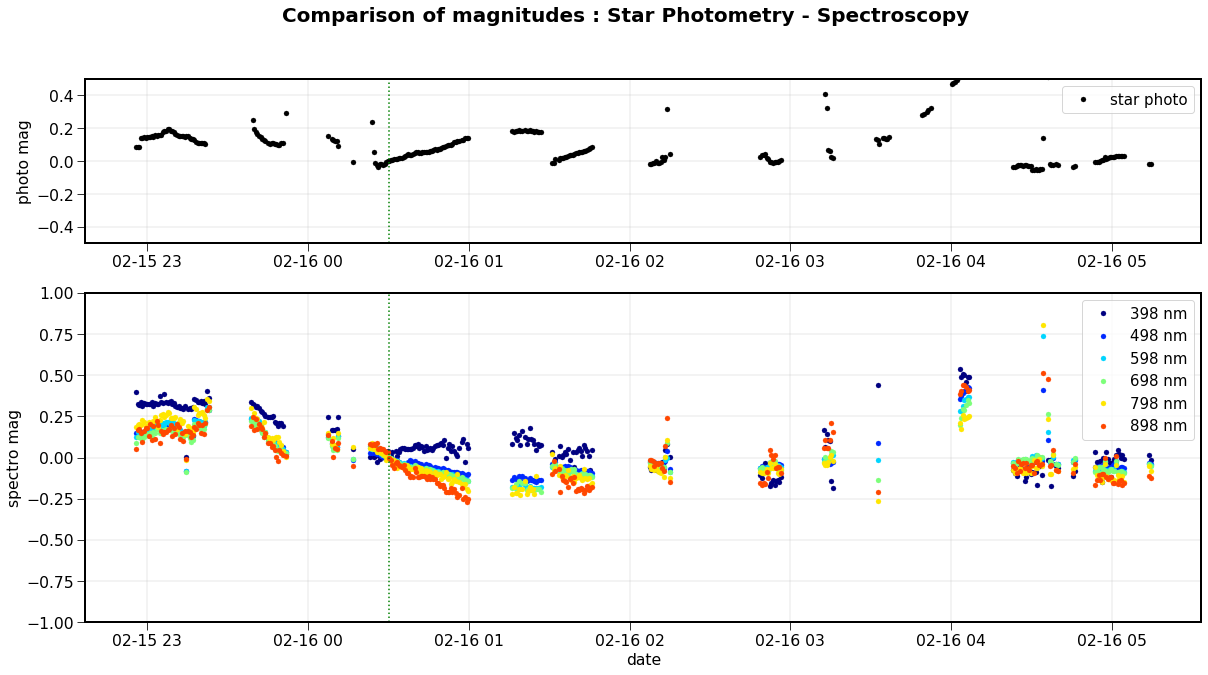

In [52]:
plt.figure(figsize=(20,10))

gs = gridspec.GridSpec(2, 1,height_ratios=[1, 2])

ax1 = plt.subplot(gs[0,0])

Deltamag1=t1["starmag"]-t1["starmag"][idx_ref1] 

ax1.plot(all_datetime1,Deltamag1,'ko',label="star photo")
#ax1.set_ylim(-16.5,-15.5)
ax1.set_ylim(-0.5,0.5)
ax1.plot([all_datetime1[idx_ref1],all_datetime1[idx_ref1]],[-0.5,0.5],'g:')


ax1.set_ylabel("photo mag")
ax1.grid()
ax1.legend(fontsize=15)
ax2 = plt.subplot(gs[1,0],sharex=ax1)

count=0
for iwl in all_idxwl:

    Deltamag2= MMag_mean_ALL[iwl,map_photo_to_spectro_idx]- MMag_mean_ALL[iwl,idx_ref2]  
    ax2.plot(all_datetime1,Deltamag2,'o',
             color=all_colors[count],label="{:3.0f} nm".format(Lambdas_ref[iwl]))
    
    count+=1
ax2.plot([all_datetime1[idx_ref1],all_datetime1[idx_ref1]],[-1,1],'g:')


ax2.grid()
ax2.legend(fontsize=15)
ax2.set_ylabel("spectro mag")
ax2.set_ylim(-1.,1.)
ax2.set_xlabel("date")
plt.suptitle("Comparison of magnitudes : Star Photometry - Spectroscopy",fontweight="bold",fontsize=20)

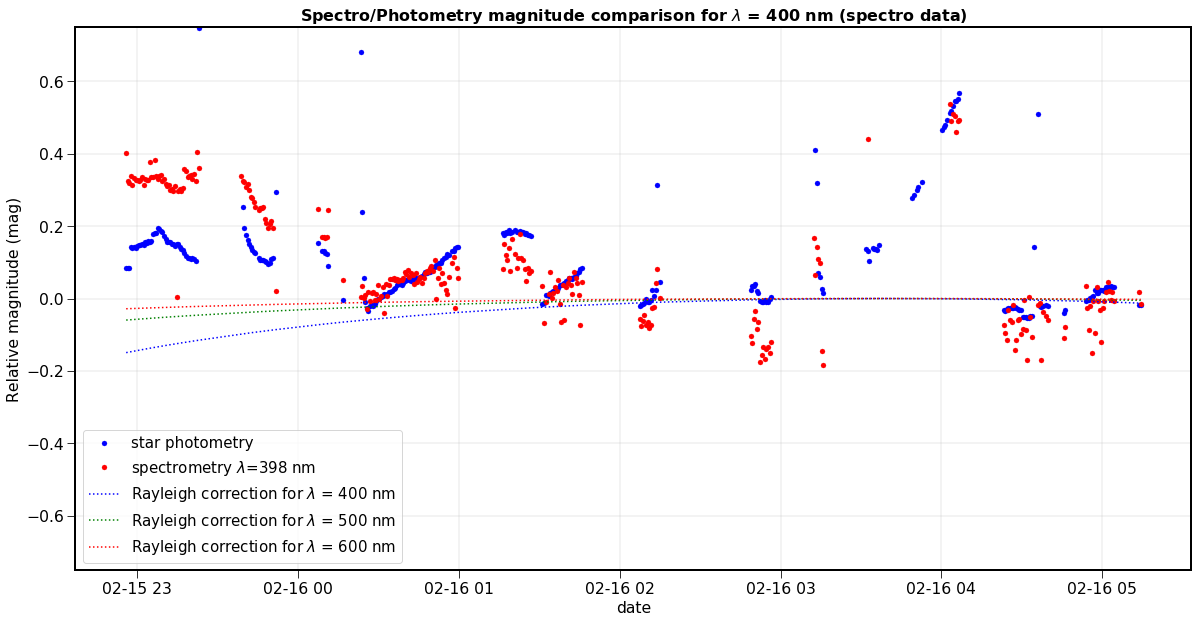

In [31]:
plt.figure(figsize=(20,10))

Deltamag1=t1["starmag"]-t1["starmag"][idx_ref1] 

plt.plot(all_datetime1,Deltamag1,'bo',label="star photometry")

Deltamag2= MMag_mean_ALL[all_idxwl[0],map_photo_to_spectro_idx]- MMag_mean_ALL[all_idxwl[0],idx_ref2] 

plt.plot(all_datetime1,Deltamag2,'ro',label="spectrometry $\lambda$={:3.0f} nm".format(Lambdas_ref[all_idxwl[0]]))
plt.ylim(-0.75,0.75)
plt.grid()
plt.legend()
mcolors=["b","g","r"]
ii=0
for wl in [400.,500.,600.]:
    od_adiab = RayOptDepth_adiabatic(wl,altitude=2890.5, costh=1./t1["airmass"]) - RayOptDepth_adiabatic(wl,altitude=2890.5, costh=1.) # Rayleigh optical depth
    label="Rayleigh correction for $\lambda$ = {:3.0f} nm".format(wl)
    plt.plot(all_datetime1,-2.5/np.log(10.)*od_adiab,':',color=mcolors[ii],label=label)
    ii+=1
    
plt.title("Spectro/Photometry magnitude comparison for $\lambda$ = 400 nm (spectro data)")
plt.xlabel("date")
plt.ylabel("Relative magnitude (mag)")
plt.legend(fontsize=15)

# Positions

In [32]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=Nobs1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(Nobs1), alpha=1)

<Figure size 432x432 with 0 Axes>

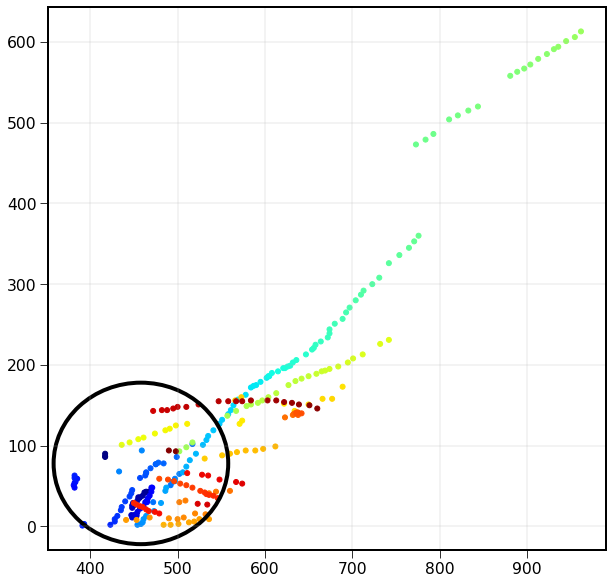

In [33]:
plt.figure(figsize=(6,6))
fig, ax = plt.subplots() 
plt.scatter(t1["x0"],t1["y0"],marker="o",c=all_colors)
circ=plt.Circle((458, 78), 100, color='k',lw=4,fill=False)
ax.add_artist(circ)
plt.grid()
#plt.xlim(0,2000)
#plt.ylim(0,2000)
#plt.show()

In [34]:
circles_indexes=np.where((t1["x0"]-458)**2+(t1["y0"]-78)**2<100**2)[0]

In [35]:
circles_indexes

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92, 155, 156, 157, 180, 181, 182, 183, 184, 185, 186, 187, 188,
       199, 200, 207, 208, 209, 210, 211, 212, 214, 215, 216, 217, 218,
       219, 220, 221, 222, 223, 224, 225, 238, 239, 240, 241, 242, 243,
       244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
       257, 258, 259, 260, 261, 264, 265, 266, 267, 268, 269, 270, 271,
       272, 285, 286])

In [36]:
map_photo_to_spectro_idx[circles_indexes]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  46,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  95, 103, 105, 106, 107, 108, 109, 110, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 199, 200, 201, 225, 226, 227, 228, 229, 230, 231, 232, 233,
       245, 246, 255, 256, 257, 258, 259, 260, 264, 265, 266, 268, 269,
       270, 271, 272, 273, 274, 276, 277, 296, 297, 298, 299, 300, 301,
       302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314,
       315, 318, 319, 320, 321, 324, 325, 326, 327, 328, 329, 330, 331,
       332, 345, 346])

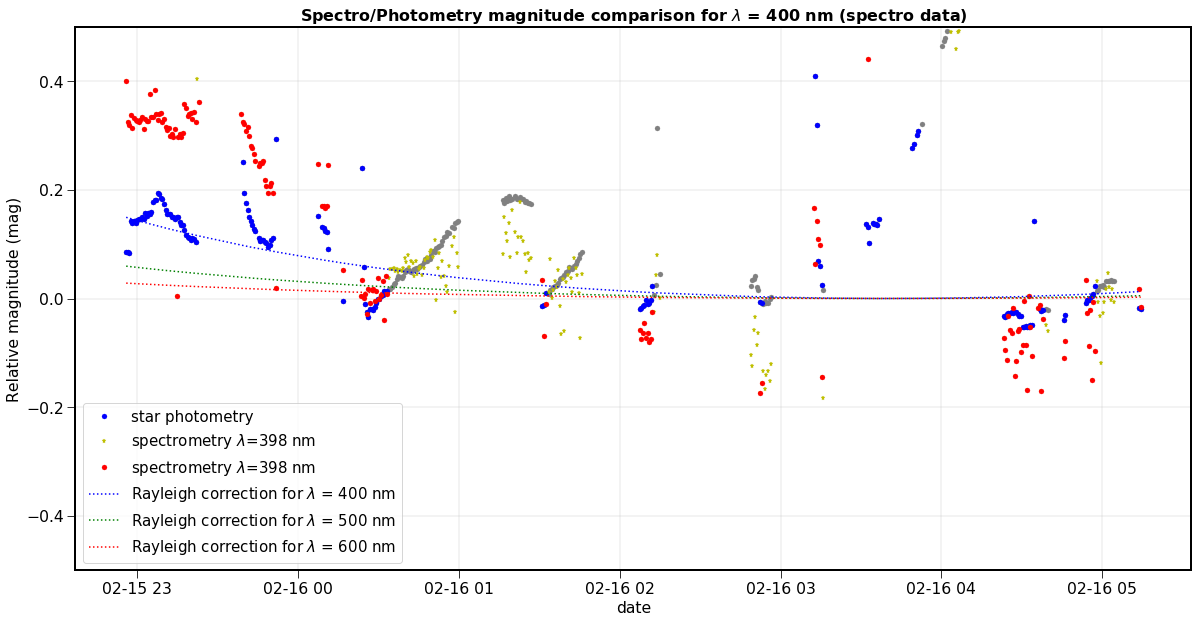

In [40]:
plt.figure(figsize=(20,10))

Deltamag1=t1["starmag"]-t1["starmag"][idx_ref1] 
Deltamag1_circ= Deltamag1[circles_indexes]

plt.plot(all_datetime1,Deltamag1,'o',color="grey")
plt.plot(all_datetime1[circles_indexes],Deltamag1_circ,'o',color="blue",label="star photometry")

Deltamag2= MMag_mean_ALL[all_idxwl[0],map_photo_to_spectro_idx]- MMag_mean_ALL[all_idxwl[0],idx_ref2] 
Deltamag2_circ= MMag_mean_ALL[all_idxwl[0],map_photo_to_spectro_idx[circles_indexes]]- MMag_mean_ALL[all_idxwl[0],idx_ref2] 


plt.plot(all_datetime1,Deltamag2,'*',color="y",label="spectrometry $\lambda$={:3.0f} nm".format(Lambdas_ref[all_idxwl[0]]))
plt.plot(all_datetime1[circles_indexes],Deltamag2_circ,'o',color="red",label="spectrometry $\lambda$={:3.0f} nm".format(Lambdas_ref[all_idxwl[0]]))

plt.ylim(-0.5,0.5)
plt.grid()
plt.legend()
mcolors=["b","g","r"]
ii=0
for wl in [400.,500.,600.]:
    od_adiab = RayOptDepth_adiabatic(wl,altitude=2890.5, costh=1./t1["airmass"]) - RayOptDepth_adiabatic(wl,altitude=2890.5, costh=1.) # Rayleigh optical depth
    label="Rayleigh correction for $\lambda$ = {:3.0f} nm".format(wl)
    plt.plot(all_datetime1,2.5/np.log(10.)*od_adiab,':',color=mcolors[ii],label=label)
    ii+=1
    
plt.title("Spectro/Photometry magnitude comparison for $\lambda$ = 400 nm (spectro data)")
plt.xlabel("date")
plt.ylabel("Relative magnitude (mag)")
plt.legend(fontsize=15)
plt.show()

In [45]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSELW)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSELW), alpha=1)

Text(0.5, 0.98, 'Comparison of magnitudes : Star Photometry - Spectroscopy')

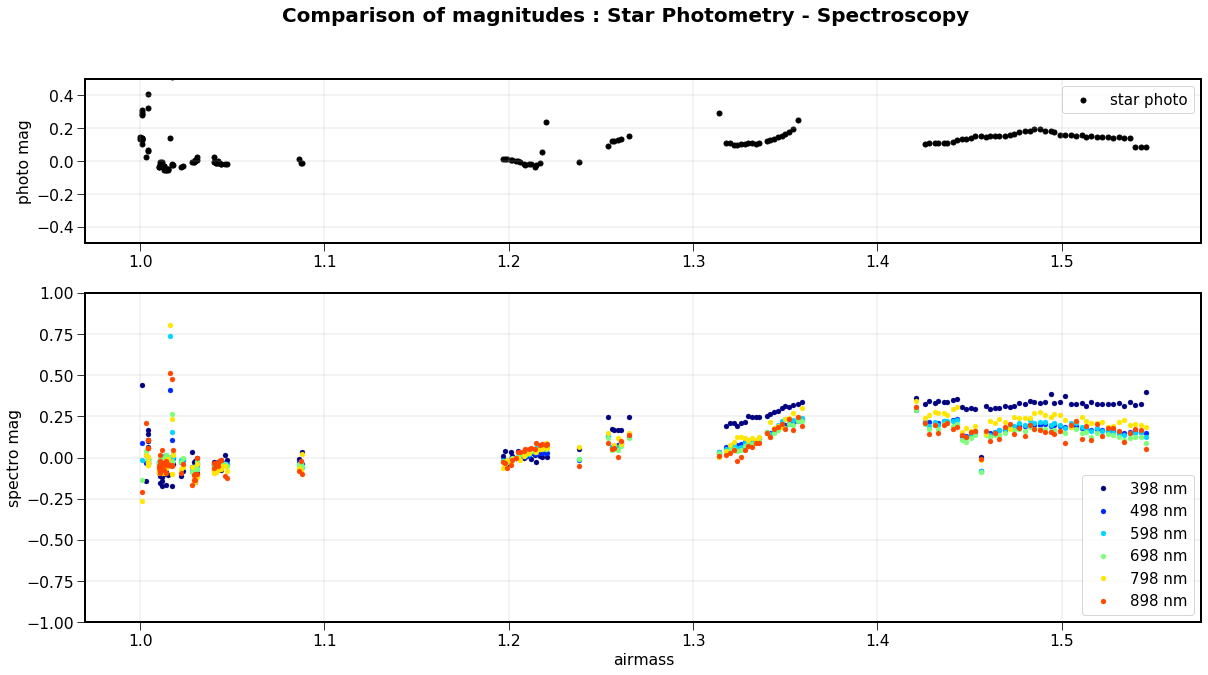

In [51]:
plt.figure(figsize=(20,10))

gs = gridspec.GridSpec(2, 1,height_ratios=[1, 2])

ax1 = plt.subplot(gs[0,0])

Deltamag1=t1["starmag"]-t1["starmag"][idx_ref1]
Deltamag1_circ= Deltamag1[circles_indexes].data
Deltamag1_airmass=t1["airmass"][circles_indexes].data


ax1.scatter(Deltamag1_airmass,Deltamag1_circ,marker="o",color="k",label="star photo")
#ax1.set_ylim(-16.5,-15.5)
ax1.set_ylim(-0.5,0.5)
#ax1.plot([t1["airmass"][idx_ref1],t1["airmass"][idx_ref1]],[-0.5,0.5],'g:')


ax1.set_ylabel("photo mag")
ax1.grid()
ax1.legend(fontsize=15)
ax2 = plt.subplot(gs[1,0],sharex=ax1)

count=0
for iwl in all_idxwl:

    Deltamag2= MMag_mean_ALL[iwl,map_photo_to_spectro_idx[circles_indexes]]- MMag_mean_ALL[iwl,idx_ref2] 
    Deltamag2_airmass=t1["airmass"][circles_indexes].data


    ax2.plot(Deltamag2_airmass,Deltamag2, 'o',
             color=all_colors[count],label="{:3.0f} nm".format(Lambdas_ref[iwl]))
    
    count+=1
#ax2.plot([all_datetime1[idx_ref1],all_datetime1[idx_ref1]],[-1,1],'g:')


ax2.grid()
ax2.legend(fontsize=15)
ax2.set_ylabel("spectro mag")
ax2.set_ylim(-1.,1.)
ax2.set_xlabel("airmass")
plt.suptitle("Comparison of magnitudes : Star Photometry - Spectroscopy",fontweight="bold",fontsize=20)